In [ ]:
import pandas as pd
import numpy as np

# --- 1. Load the Dataset ---
print("--- Loading Data ---")
try:
    # Make sure 'processedData1.csv' is in the same directory as your script
    # or provide the full path to the file.
    df = pd.read_csv('/content/TransactionSamples.csv')
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'processedData1.csv' not found. Please make sure the file is in the correct directory.")
    exit()

# --- 2. Preprocessing Steps ---
print("\n--- 📈 Preprocessing Steps ---")

# Null Value Handling
print("\n--- Null Value Handling ---")
null_values = df.isnull().sum()
print("Number of null values in each column:")
print(null_values[null_values > 0])
if not null_values.any():
    print("No null values found in the dataset.")


# Outlier Detection (using IQR method on TranAmount)
print("\n--- Outlier Detection on TranAmount ---")
Q1 = df['TranAmount'].quantile(0.25)
Q3 = df['TranAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['TranAmount'] < lower_bound) | (df['TranAmount'] > upper_bound)]
print(f"Number of outliers detected in TranAmount: {len(outliers)}")
if not outliers.empty:
    print("Sample of detected outliers:")
    print(outliers.head())

# --- 3. Analytical Work ---
print("\n--- 🔍 Analytical Work ---")

# Duplicates Analysis
print("\n--- Duplicates Analysis ---")
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows found: {duplicate_rows}")

# Relative Size Factor (RSF) Analysis
print("\n--- Relative Size Factor (RSF) Analysis ---")
# Group by sender ID and get the two largest transactions
grouped = df.groupby('sId')['TranAmount'].nlargest(2).reset_index()

# Directly access the largest and second largest amounts
rsf_data = grouped.groupby('sId')['TranAmount'].agg(['first', 'last']).reset_index()
rsf_data.columns = ['sId', 'largest_amount', 'second_largest_amount']

# Calculate RSF
rsf_data.dropna(inplace=True) # Only consider senders with at least 2 transactions
rsf_data['RSF'] = rsf_data['largest_amount'] / rsf_data['second_largest_amount']

# Display high RSF values (e.g., RSF > 2)
high_rsf = rsf_data[rsf_data['RSF'] > 2].sort_values(by='RSF', ascending=False)
print(f"Number of senders with a high Relative Size Factor (RSF > 2): {len(high_rsf)}")
if not high_rsf.empty:
    print("Senders with the highest RSF values:")
    print(high_rsf.head())


# --- 4. Data Analysis ---
print("\n--- 🧮 Data Analysis ---")

# Conformity Assessment (Balance Check)
print("\n--- Conformity Assessment: Balance Check ---")
# Check if sBalbefore - sBalAfter is approximately equal to TranAmount
df['balance_diff'] = df['sBalbefore'] - df['sBalAfter']
# Using np.isclose for floating point comparison to handle small precision differences
df['is_consistent'] = np.isclose(df['balance_diff'], df['TranAmount'])

inconsistent_transactions = df[~df['is_consistent']]
print(f"Number of transactions with inconsistent balance updates: {len(inconsistent_transactions)}")
if not inconsistent_transactions.empty:
    print("Sample of inconsistent transactions:")
    print(inconsistent_transactions[['sId', 'sBalbefore', 'sBalAfter', 'TranAmount', 'balance_diff']].head())

# --- 5. Findings & Observations ---
print("\n--- ⚠️ Preliminary Findings & Observations ---")
print(f"- *Outliers*: {len(outliers)} transactions were flagged as potential outliers based on their amount.")
print(f"- *Duplicates*: {duplicate_rows} duplicate rows were identified.")
print(f"- *High RSF*: {len(high_rsf)} senders showed a high Relative Size Factor, indicating unusually large transactions compared to their second-largest ones.")
print(f"- *Inconsistent Balances*: {len(inconsistent_transactions)} transactions had inconsistencies between the transaction amount and the change in the sender's balance.")
print("\nThese flagged entries warrant further investigation.")

--- Loading Data ---
Dataset loaded successfully.
Shape of the dataset: (54222, 25)

First 5 rows of the dataset:
          gT           sId          rId        sAcc        rAcc  TranAmount  \
0  N-RegDep        PN_Ret2  PN_EU_0_261       RAcc2  EUAcc0_261   131926.49   
1  N_Reg_RC    PN_EU_1_502     operator  EUAcc1_502          A0     2054.46   
2  N-RegDep        PN_Ret2  PN_EU_1_362       RAcc2  EUAcc1_362   182548.74   
3  N_Reg_RC     PN_EU_1_26     operator   EUAcc1_26          A0     5507.28   
4  N_Reg_RC     PN_EU_1_18     operator   EUAcc1_18          A0     2102.60   

  TranType TranStatus    sBalbefore     sBalAfter  ...  sf4               sTD  \
0       Dt         SU  1.000000e+09  9.998681e+08  ...  NaN  1/6/2011 0:11:22   
1     ArRC         SU  1.000000e+08  9.999795e+07  ...  NaN   1/6/2011 0:16:8   
2       Dt         SU  9.998681e+08  9.996855e+08  ...  NaN  1/6/2011 0:36:47   
3     ArRC         SU  1.000000e+08  9.999449e+07  ...  NaN  1/6/2011 0:36:59   
4     

# Task
Analyze the flagged transactions to identify patterns and characteristics that distinguish them from normal transactions.

## Select flagged transactions

### Subtask:
Create separate dataframes for each type of flagged transaction (outliers, high RSF, inconsistent balances).


**Reasoning**:
Creating separate dataframes for each type of flagged transaction as per the instructions.



In [ ]:
df_outliers = df[df.index.isin(outliers.index)].copy()
df_high_rsf = df[df['sId'].isin(high_rsf['sId'])].copy()
df_inconsistent_balances = df[df.index.isin(inconsistent_transactions.index)].copy()

print("Shape of df_outliers:", df_outliers.shape)
print("Shape of df_high_rsf:", df_high_rsf.shape)
print("Shape of df_inconsistent_balances:", df_inconsistent_balances.shape)

Shape of df_outliers: (4289, 27)
Shape of df_high_rsf: (477, 27)
Shape of df_inconsistent_balances: (13094, 27)


## Analyze transaction types

### Subtask:
Examine the distribution of `TranType` for each group of flagged transactions.


**Reasoning**:
Calculate and print the transaction type distributions for each of the flagged transaction dataframes.



In [ ]:
print("--- Transaction Type Distribution for Outliers ---")
display(df_outliers['TranType'].value_counts())

print("\n--- Transaction Type Distribution for High RSF Transactions ---")
display(df_high_rsf['TranType'].value_counts())

print("\n--- Transaction Type Distribution for Inconsistent Balances ---")
display(df_inconsistent_balances['TranType'].value_counts())

--- Transaction Type Distribution for Outliers ---


,count
TranType,
Dt,2409
Wl,1536
Ind,304
Merchant,40



--- Transaction Type Distribution for High RSF Transactions ---


,count
TranType,
ArRC,339
Wl,76
Ind,62



--- Transaction Type Distribution for Inconsistent Balances ---


,count
TranType,
Ind,8234
Wl,4860


## Analyze sender and receiver types

### Subtask:
Investigate the distribution of `sType` and `rType` for each group of flagged transactions.


**Reasoning**:
Calculate and display the value counts for 'sType' and 'rType' for each of the three flagged transaction dataframes.



In [ ]:
# Analysis for df_outliers
print("--- Sender Type Distribution for Outlier Transactions ---")
display(df_outliers['sType'].value_counts())

print("\n--- Receiver Type Distribution for Outlier Transactions ---")
display(df_outliers['rType'].value_counts())

# Analysis for df_high_rsf
print("\n--- Sender Type Distribution for High RSF Transactions ---")
display(df_high_rsf['sType'].value_counts())

print("\n--- Receiver Type Distribution for High RSF Transactions ---")
display(df_high_rsf['rType'].value_counts())

# Analysis for df_inconsistent_balances
print("\n--- Sender Type Distribution for Inconsistent Balance Transactions ---")
display(df_inconsistent_balances['sType'].value_counts())

print("\n--- Receiver Type Distribution for Inconsistent Balance Transactions ---")
display(df_inconsistent_balances['rType'].value_counts())

--- Sender Type Distribution for Outlier Transactions ---


,count
sType,
RET,2409
EU,1880



--- Receiver Type Distribution for Outlier Transactions ---


,count
rType,
EU,2713
RET,1536
MER,40



--- Sender Type Distribution for High RSF Transactions ---


,count
sType,
EU,477



--- Receiver Type Distribution for High RSF Transactions ---


,count
rType,
operator,339
RET,76
EU,62



--- Sender Type Distribution for Inconsistent Balance Transactions ---


,count
sType,
EU,13094



--- Receiver Type Distribution for Inconsistent Balance Transactions ---


,count
rType,
EU,8234
RET,4860


## Analyze transaction amounts

### Subtask:
Analyze the distribution of `TranAmount` for the inconsistent and high RSF transactions.


**Reasoning**:
Analyze the distribution of TranAmount for the inconsistent and high RSF transactions by printing descriptive summaries and calculating mean and median.



In [ ]:
print("--- Descriptive Summary of TranAmount for Inconsistent Balance Transactions ---")
display(df_inconsistent_balances['TranAmount'].describe())

print("\n--- Descriptive Summary of TranAmount for High RSF Transactions ---")
display(df_high_rsf['TranAmount'].describe())

# Calculate and print mean and median
mean_inconsistent = df_inconsistent_balances['TranAmount'].mean()
median_inconsistent = df_inconsistent_balances['TranAmount'].median()
mean_high_rsf = df_high_rsf['TranAmount'].mean()
median_high_rsf = df_high_rsf['TranAmount'].median()

print(f"\nMean TranAmount for Inconsistent Balance Transactions: {mean_inconsistent:.2f}")
print(f"Median TranAmount for Inconsistent Balance Transactions: {median_inconsistent:.2f}")

print(f"\nMean TranAmount for High RSF Transactions: {mean_high_rsf:.2f}")
print(f"Median TranAmount for High RSF Transactions: {median_high_rsf:.2f}")


--- Descriptive Summary of TranAmount for Inconsistent Balance Transactions ---


,TranAmount
count,1.309400e+04
mean,9.550320e+04
std,1.042210e+05
min,3.805000e+01
25%,2.341501e+04
50%,6.367445e+04
75%,1.260257e+05
max,1.053513e+06



--- Descriptive Summary of TranAmount for High RSF Transactions ---


,TranAmount
count,477.000000
mean,19114.411174
std,51858.582142
min,1.020000
25%,1249.030000
50%,2819.340000
75%,7295.700000
max,533136.240000



Mean TranAmount for Inconsistent Balance Transactions: 95503.20
Median TranAmount for Inconsistent Balance Transactions: 63674.45

Mean TranAmount for High RSF Transactions: 19114.41
Median TranAmount for High RSF Transactions: 2819.34


## Analyze balance differences

### Subtask:
Focus on the inconsistent balance transactions and analyze the distribution of `balance_diff`.


**Reasoning**:
Calculate and display descriptive statistics for the `balance_diff` column in the `df_inconsistent_balances` DataFrame and then calculate and print the mean and median of the `balance_diff` column.



In [ ]:
print("--- Descriptive Statistics for balance_diff in Inconsistent Balance Transactions ---")
display(df_inconsistent_balances['balance_diff'].describe())

mean_balance_diff = df_inconsistent_balances['balance_diff'].mean()
median_balance_diff = df_inconsistent_balances['balance_diff'].median()

print(f"\nMean balance_diff for Inconsistent Balance Transactions: {mean_balance_diff:.2f}")
print(f"Median balance_diff for Inconsistent Balance Transactions: {median_balance_diff:.2f}")

--- Descriptive Statistics for balance_diff in Inconsistent Balance Transactions ---


,balance_diff
count,1.309400e+04
mean,9.645823e+04
std,1.052632e+05
min,3.843000e+01
25%,2.364916e+04
50%,6.431120e+04
75%,1.272860e+05
max,1.064048e+06



Mean balance_diff for Inconsistent Balance Transactions: 96458.23
Median balance_diff for Inconsistent Balance Transactions: 64311.20


## Visualize findings

### Subtask:
Create visualizations (e.g., bar plots, histograms) to illustrate the key characteristics of the flagged transactions.


**Reasoning**:
Generate bar plots for the distribution of `TranType` for the three flagged dataframes and histograms for `TranAmount` and `balance_diff` as requested in the instructions.



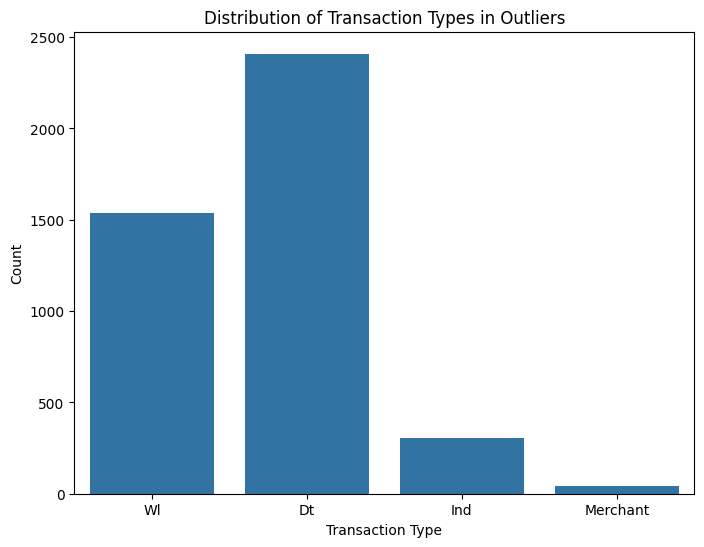

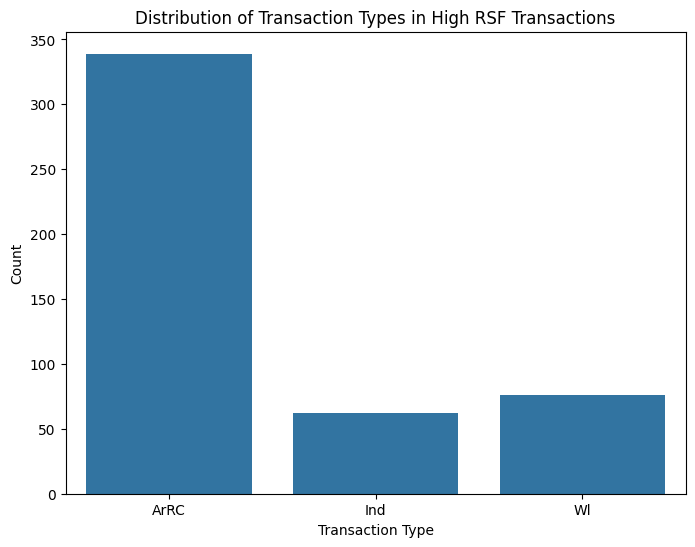

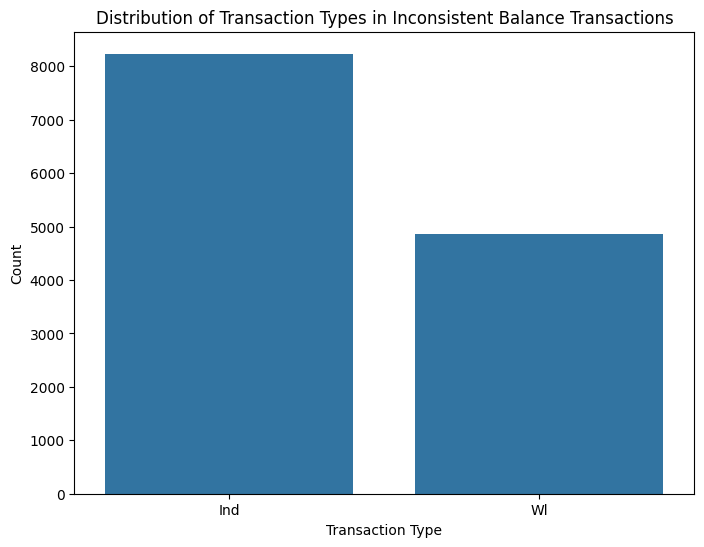

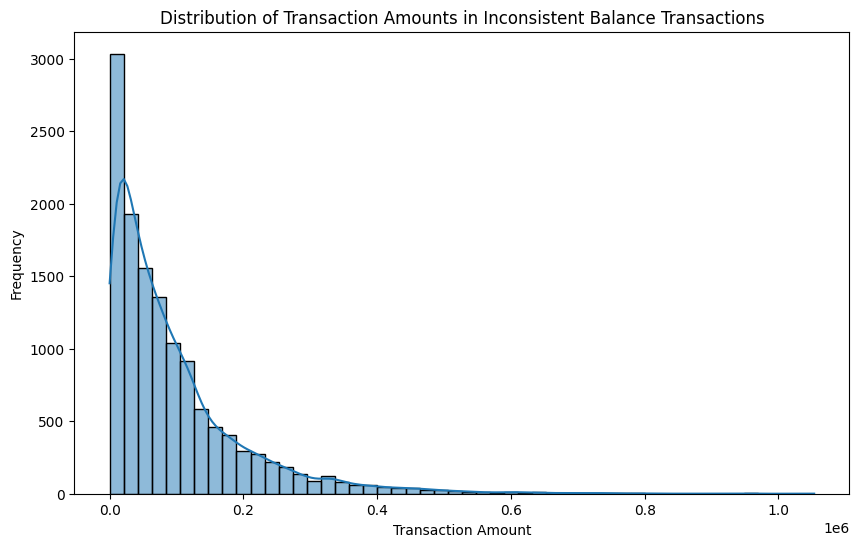

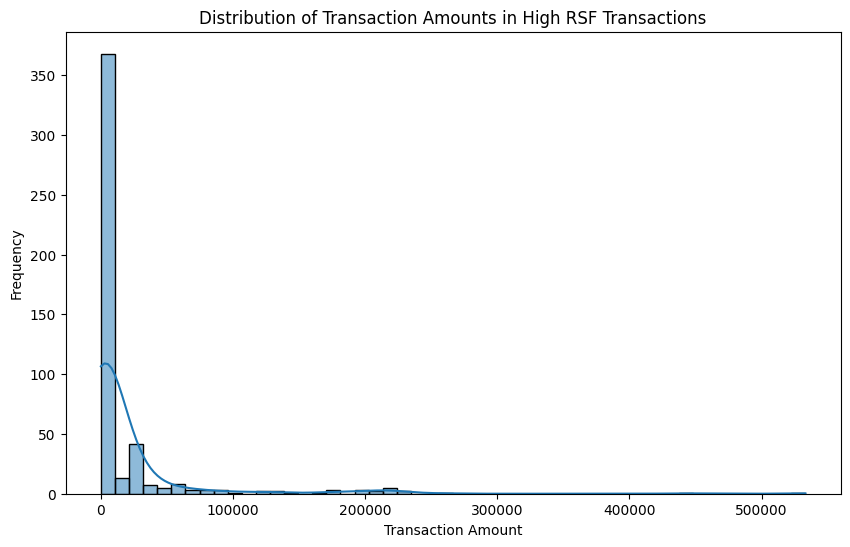

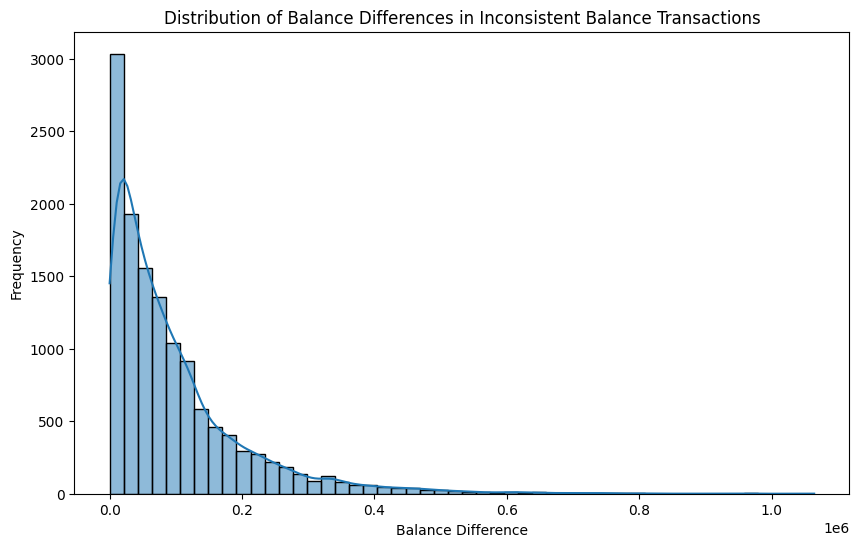

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of TranType for df_outliers
plt.figure(figsize=(8, 6))
sns.countplot(data=df_outliers, x='TranType')
plt.title('Distribution of Transaction Types in Outliers')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

# 2. Distribution of TranType for df_high_rsf
plt.figure(figsize=(8, 6))
sns.countplot(data=df_high_rsf, x='TranType')
plt.title('Distribution of Transaction Types in High RSF Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

# 3. Distribution of TranType for df_inconsistent_balances
plt.figure(figsize=(8, 6))
sns.countplot(data=df_inconsistent_balances, x='TranType')
plt.title('Distribution of Transaction Types in Inconsistent Balance Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

# 4. Histogram of TranAmount for df_inconsistent_balances
plt.figure(figsize=(10, 6))
sns.histplot(data=df_inconsistent_balances, x='TranAmount', bins=50, kde=True)
plt.title('Distribution of Transaction Amounts in Inconsistent Balance Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# 5. Histogram of TranAmount for df_high_rsf
plt.figure(figsize=(10, 6))
sns.histplot(data=df_high_rsf, x='TranAmount', bins=50, kde=True)
plt.title('Distribution of Transaction Amounts in High RSF Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# 6. Histogram of balance_diff for df_inconsistent_balances
plt.figure(figsize=(10, 6))
sns.histplot(data=df_inconsistent_balances, x='balance_diff', bins=50, kde=True)
plt.title('Distribution of Balance Differences in Inconsistent Balance Transactions')
plt.xlabel('Balance Difference')
plt.ylabel('Frequency')
plt.show()

## Summarize findings

### Subtask:
Provide a summary of the key observations about the flagged transactions.


**Reasoning**:
Synthesize the findings from the previous analysis steps into a concise summary highlighting the distinct characteristics of each flagged group and compare them.



In [ ]:
print("--- Summary of Flagged Transaction Characteristics ---")

print("\n**Outlier Transactions (based on TranAmount):**")
print("- Primarily characterized by unusually high transaction amounts compared to the rest of the dataset, as identified by the IQR method.")
print(f"- The dominant transaction types are '{df_outliers['TranType'].value_counts().index[0]}' and '{df_outliers['TranType'].value_counts().index[1]}'.")
print(f"- Sender types are mainly '{df_outliers['sType'].value_counts().index[0]}' and '{df_outliers['sType'].value_counts().index[1]}', while receiver types are primarily '{df_outliers['rType'].value_counts().index[0]}' and '{df_outliers['rType'].value_counts().index[1]}'.")


print("\n**High Relative Size Factor (RSF) Transactions:**")
print("- Identified by a large ratio between the largest and second-largest transaction amounts for a given sender, suggesting a significantly larger transaction event for that sender.")
print(f"- The most frequent transaction type is '{df_high_rsf['TranType'].value_counts().index[0]}'.")
print(f"- Sender types are exclusively '{df_high_rsf['sType'].value_counts().index[0]}'.")
print(f"- Receiver types are predominantly '{df_high_rsf['rType'].value_counts().index[0]}', '{df_high_rsf['rType'].value_counts().index[1]}', and '{df_high_rsf['rType'].value_counts().index[2]}'.")
print(f"- While flagged by RSF, the absolute transaction amounts are generally lower (Mean: {df_high_rsf['TranAmount'].mean():.2f}, Median: {df_high_rsf['TranAmount'].median():.2f}) compared to transactions flagged as outliers based purely on amount.")

print("\n**Inconsistent Balance Transactions:**")
print("- These transactions show a discrepancy between the transaction amount and the change in the sender's balance.")
print(f"- The primary transaction types are '{df_inconsistent_balances['TranType'].value_counts().index[0]}' and '{df_inconsistent_balances['TranType'].value_counts().index[1]}'.")
print(f"- Sender types are exclusively '{df_inconsistent_balances['sType'].value_counts().index[0]}'.")
print(f"- Receiver types are mainly '{df_inconsistent_balances['rType'].value_counts().index[0]}' and '{df_inconsistent_balances['rType'].value_counts().index[1]}'.")
print(f"- These transactions involve a wide range of amounts (Mean TranAmount: {df_inconsistent_balances['TranAmount'].mean():.2f}, Median TranAmount: {df_inconsistent_balances['TranAmount'].median():.2f}).")
print(f"- The 'balance_diff' (sBalbefore - sBalAfter) in this group has a mean of {df_inconsistent_balances['balance_diff'].mean():.2f} and a median of {df_inconsistent_balances['balance_diff'].median():.2f}, indicating the magnitude of the inconsistency.")

print("\n**Comparative Analysis:**")
print("- Outliers based on amount tend to involve large sums regardless of sender/receiver types or transaction type distribution, although certain types are more frequent.")
print("- High RSF transactions highlight senders with disproportionately large individual transactions relative to their history, often involving specific transaction types ('ArRC') and 'EU' senders interacting with 'operator' or 'RET' receivers. Their absolute amounts are lower than general outliers.")
print("- Inconsistent balance transactions point to data integrity issues or potential manipulation. They involve a significant portion of the dataset and cover a broader range of transaction amounts than high RSF transactions, although generally lower than the most extreme outliers. The inconsistency is focused on 'EU' senders and 'EU' or 'RET' receivers, with 'Ind' and 'Wl' transaction types being most common.")

--- Summary of Flagged Transaction Characteristics ---

**Outlier Transactions (based on TranAmount):**
- Primarily characterized by unusually high transaction amounts compared to the rest of the dataset, as identified by the IQR method.
- The dominant transaction types are 'Dt' and 'Wl'.
- Sender types are mainly 'RET' and 'EU', while receiver types are primarily 'EU' and 'RET'.

**High Relative Size Factor (RSF) Transactions:**
- Identified by a large ratio between the largest and second-largest transaction amounts for a given sender, suggesting a significantly larger transaction event for that sender.
- The most frequent transaction type is 'ArRC'.
- Sender types are exclusively 'EU'.
- Receiver types are predominantly 'operator', 'RET', and 'EU'.
- While flagged by RSF, the absolute transaction amounts are generally lower (Mean: 19114.41, Median: 2819.34) compared to transactions flagged as outliers based purely on amount.

**Inconsistent Balance Transactions:**
- These transaction

## Summary:

### Data Analysis Key Findings

*   The analysis identified three distinct groups of flagged transactions: Outliers (based on `TranAmount`), High RSF (Relative Size Factor), and Inconsistent Balances.
*   Outlier transactions primarily involved 'Dt' and 'Wl' transaction types, with sender types ('sType') being mainly 'RET' and 'EU', and receiver types ('rType') mainly 'EU' and 'RET'.
*   High RSF transactions were dominated by the 'ArRC' transaction type, exclusively involved 'EU' senders, and predominantly involved 'operator', 'RET', and 'EU' receivers. The transaction amounts in this group were generally lower than those in the general outlier group (Mean: \$19,114, Median: \$2,819).
*   Inconsistent Balance transactions showed a discrepancy between transaction amount and balance change. These were primarily 'Ind' and 'Wl' transaction types, exclusively involved 'EU' senders, and mainly involved 'EU' and 'RET' receivers. These transactions had a wide range of amounts (Mean: \$95,503, Median: \$63,674) and a mean balance difference of \$96,458.23.
*   Visualizations confirmed these distributions, showing the prevalence of specific transaction types and highlighting the different ranges of transaction amounts and balance differences within the flagged groups.

### Insights or Next Steps

*   The distinct characteristics of each flagged group suggest that different detection rules or monitoring strategies may be required for each type of suspicious activity.
*   Further investigation into the 'ArRC' transaction type and 'EU' senders involved in high RSF transactions could provide more specific insights into the nature of this activity. The root cause of the inconsistent balance transactions, particularly the large average balance difference, warrants immediate investigation to address potential data integrity issues or fraudulent patterns.


# Task
Analyze the characteristics of the flagged transactions, including transaction types, sender and receiver types, transaction amounts, and balance differences. Investigate the 'arrc' transaction type within the high RSF transactions. Summarize the findings and suggest next steps.

## Investigate 'arrc' in high rsf

### Subtask:
Filter the high RSF transactions to specifically examine those with 'ArRC' as the `TranType` and analyze their characteristics.


**Reasoning**:
Filter the high RSF transactions for 'ArRC' transaction type and analyze its characteristics as requested.



In [ ]:
# Filter for 'ArRC' transactions within the high RSF group
df_high_rsf_arrc = df_high_rsf[df_high_rsf['TranType'] == 'ArRC'].copy()

# Print shape and head
print("Shape of df_high_rsf_arrc:", df_high_rsf_arrc.shape)
print("\nFirst 5 rows of df_high_rsf_arrc:")
display(df_high_rsf_arrc.head())

# Analyze sType and rType distribution
print("\n--- Sender Type Distribution for High RSF 'ArRC' Transactions ---")
display(df_high_rsf_arrc['sType'].value_counts())

print("\n--- Receiver Type Distribution for High RSF 'ArRC' Transactions ---")
display(df_high_rsf_arrc['rType'].value_counts())

# Analyze TranAmount distribution
print("\n--- Descriptive Statistics for TranAmount in High RSF 'ArRC' Transactions ---")
display(df_high_rsf_arrc['TranAmount'].describe())

mean_arrc_high_rsf = df_high_rsf_arrc['TranAmount'].mean()
median_arrc_high_rsf = df_high_rsf_arrc['TranAmount'].median()

print(f"\nMean TranAmount for High RSF 'ArRC' Transactions: {mean_arrc_high_rsf:.2f}")
print(f"Median TranAmount for High RSF 'ArRC' Transactions: {median_arrc_high_rsf:.2f}")

Shape of df_high_rsf_arrc: (339, 27)

First 5 rows of df_high_rsf_arrc:


,gT,sId,rId,sAcc,rAcc,TranAmount,TranType,TranStatus,sBalbefore,sBalAfter,...,rTD,sAccID,ef1,ef2,NoDescription,TranTS,sType,rType,balance_diff,is_consistent
51,N_Reg_RC,PN_EU_0_961,operator,EUAcc0_961,A0,929.78,ArRC,SU,1.000000e+08,99999070.22,...,1/6/2011 7:31:11,EUAcc0_961,NaN,NaN,Rc201161.73131,1/6/2011 7:31:11,EU,operator,929.78,True
348,N_Reg_RC,PN_EU_1_480,operator,EUAcc1_480,A0,1864.15,ArRC,SU,1.000000e+08,99998135.85,...,2/6/2011 18:48:23,EUAcc1_480,NaN,NaN,Rc201162.184848,2/6/2011 18:48:23,EU,operator,1864.15,True
438,N_Reg_RC,PN_EU_0_1194,operator,EUAcc0_1194,A0,3122.08,ArRC,SU,1.000000e+08,99996877.92,...,3/6/2011 3:23:7,EUAcc0_1194,NaN,NaN,Rc201163.32323,3/6/2011 3:23:7,EU,operator,3122.08,True
1058,N_Reg_RC,PN_EU_0_1223,operator,EUAcc0_1223,A0,526.97,ArRC,SU,9.996104e+07,99960513.64,...,5/6/2011 0:55:49,EUAcc0_1223,NaN,NaN,Rc201165.05555,5/6/2011 0:55:49,EU,operator,526.97,True
1200,N_Reg_RC,PN_EU_0_1075,operator,EUAcc0_1075,A0,423.40,ArRC,SU,1.000000e+08,99999576.60,...,5/6/2011 13:17:13,EUAcc0_1075,NaN,NaN,Rc201165.131717,5/6/2011 13:17:13,EU,operator,423.40,True



--- Sender Type Distribution for High RSF 'ArRC' Transactions ---


,count
sType,
EU,339



--- Receiver Type Distribution for High RSF 'ArRC' Transactions ---


,count
rType,
operator,339



--- Descriptive Statistics for TranAmount in High RSF 'ArRC' Transactions ---


,TranAmount
count,339.000000
mean,2194.249233
std,1891.734900
min,1.020000
25%,978.775000
50%,1920.330000
75%,3158.850000
max,17010.860000



Mean TranAmount for High RSF 'ArRC' Transactions: 2194.25
Median TranAmount for High RSF 'ArRC' Transactions: 1920.33


## Summary:

### Data Analysis Key Findings

*   There are 339 transactions of type 'ArRC' within the high RSF group.
*   For these high RSF 'ArRC' transactions, the sender type is always 'EU', and the receiver type is always 'operator'.
*   The transaction amounts for high RSF 'ArRC' transactions range from \$1.02 to \$17010.86.
*   The mean transaction amount for high RSF 'ArRC' transactions is approximately \$2194.25, with a median of \$1920.33.

### Insights or Next Steps

*   Given the consistent sender ('EU') and receiver ('operator') types for high RSF 'ArRC' transactions, further investigation into the specific nature of this transaction type and the involved parties is warranted.
*   Analyze the distribution of `TranAmount` for high RSF 'ArRC' transactions more deeply (e.g., through visualizations or percentiles) to identify potential patterns or thresholds for suspicious activity.
